In [1]:
!nvidia-smi

Thu Dec  6 20:31:39 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             On   | 00000000:03:00.0 Off |                  N/A |
| 28%   31C    P8    24W / 250W |      0MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:83:00.0 Off |                    0 |
| N/A   33C    P0    30W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

First, we grab matplotlib, and set the old "classic" style for some reason only Rui knows.

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')

In [3]:
import numpy as np
import torch

These are the local imports. Make sure you import the correct model!

In [14]:
from model.models import SimpleCNN3Layer as Model
from model.collectdata import collect_data
from model.training import select_gpu
from model.plots import plot_ruiplot
from model.efficiency import pv_locations, efficiency

Select a GPU here. Same numbering as the NVidia-SMI tool.

In [15]:
device = select_gpu(1)

1 available GPUs (initially using device 0):
  0 TITAN V


Pick a file to load.

In [16]:
validation = collect_data('data/Oct03_20K_val.h5',
                          batch_size=1,
                          slice=slice(100),
                          masking=True,
                          device=device)

Loading data...
Loaded data/Oct03_20K_val.h5 in 2.826 s
Constructing 100 event dataset took 0.002732 s


> Note: to get the real PV locations, use `collect_truth('file.h5', pvs=True)` to collect PVs (or SVs with `pvs=False`)

Let's just see how many NaNs we have in the dataset.

In [17]:
print(*np.sum(np.isnan(validation.dataset.tensors[1].cpu().numpy()), 1))

16 6 0 12 18 28 29 12 23 16 17 79 20 18 37 0 12 43 11 21 38 0 35 23 22 22 23 33 27 16 0 23 17 56 17 38 16 45 12 12 12 22 22 11 12 44 17 45 6 17 39 28 33 17 39 62 53 29 6 6 5 46 53 34 22 29 17 63 17 12 18 22 50 18 28 12 41 29 22 34 35 17 42 11 57 27 16 22 23 33 23 33 16 45 30 0 6 16 28 17


Select a model to load. Make sure it matches the model you imported above.

In [21]:
name = '../notebooks/Dec_6_mask_120000_2layer_4e-06/Dec_6_mask_120000_2layer_4e-06_final.pyt'
model = Model().to(device)
model.load_state_dict(torch.load(name))
model.eval()

SimpleCNN3Layer(
  (conv1): Conv1d(1, 10, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(10, 5, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3dropout): Dropout(p=0.35)
  (fc1): Linear(in_features=4000, out_features=4000, bias=True)
)

Let's grab the outputs and labels as normal numpy arrays.

In [22]:
%%time
with torch.no_grad():
    outputs = model(validation.dataset.tensors[0]).cpu().numpy()
    labels = validation.dataset.tensors[1].cpu().numpy()

CPU times: user 2.64 ms, sys: 3.94 ms, total: 6.58 ms
Wall time: 5.53 ms


And here's Rui's plotting code.

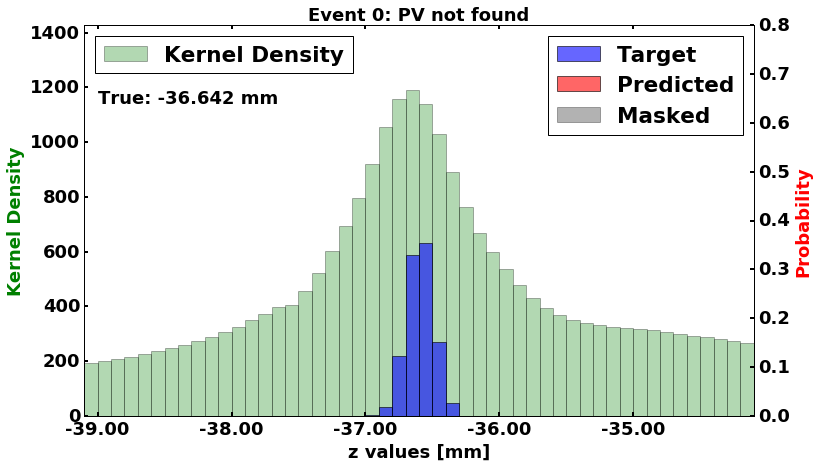

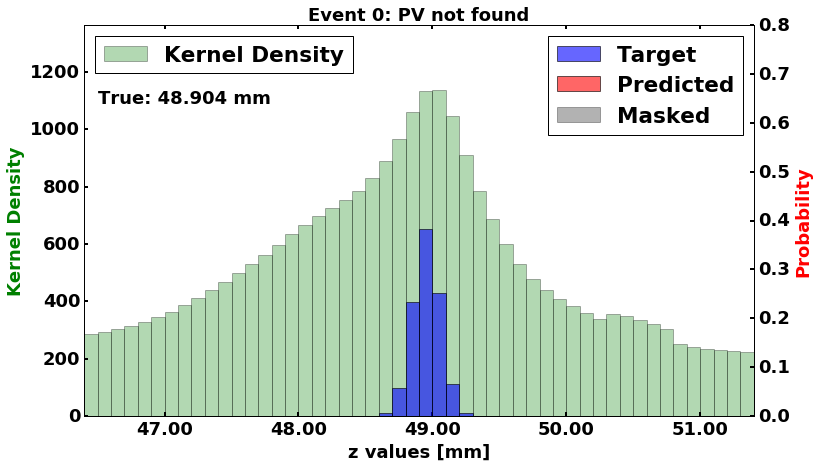

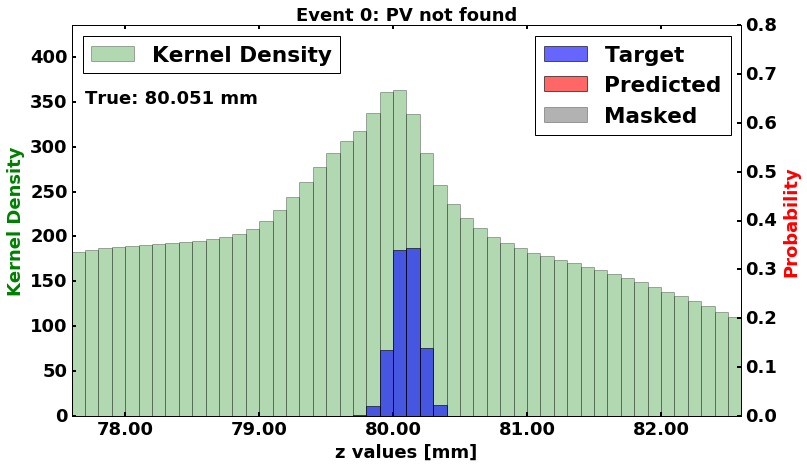

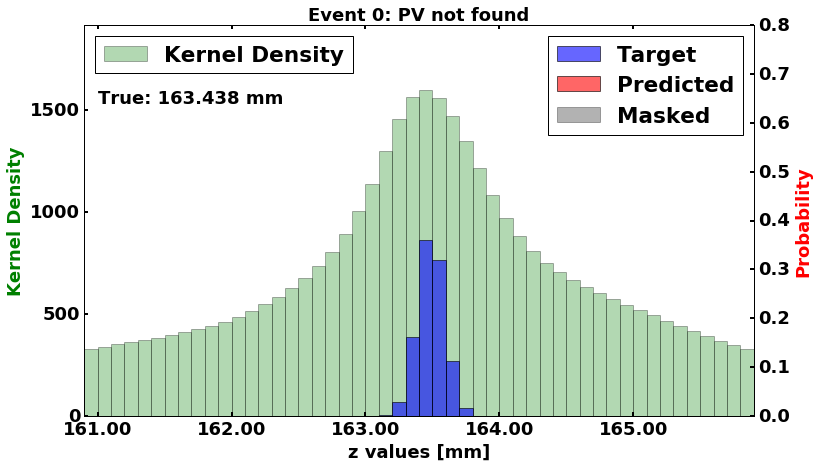

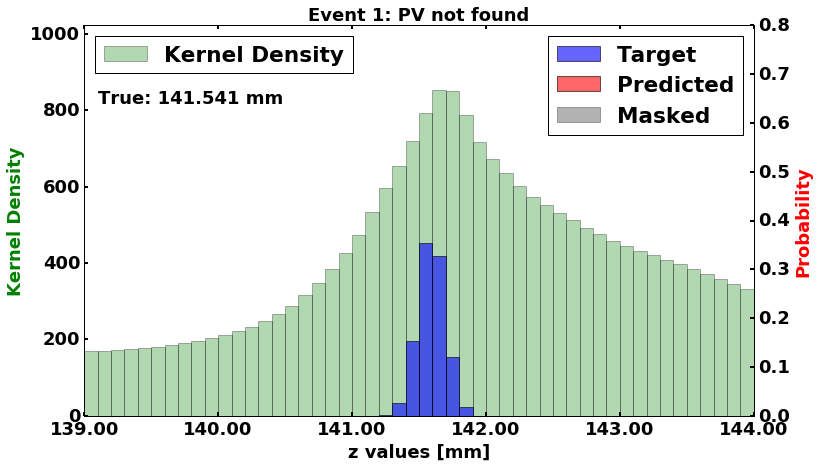

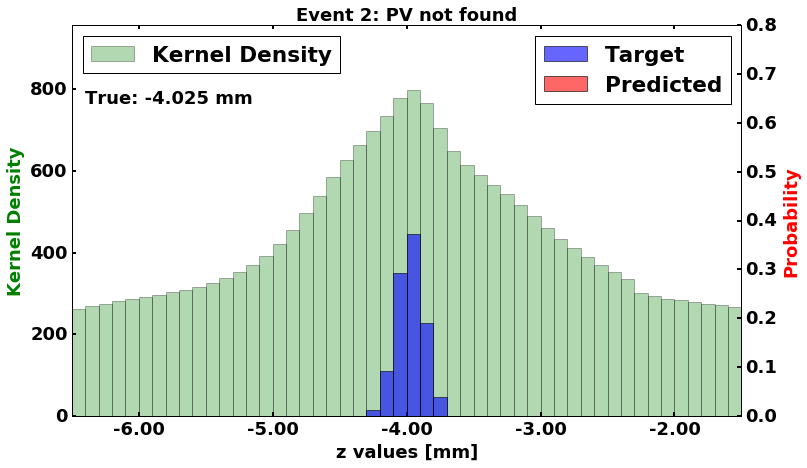

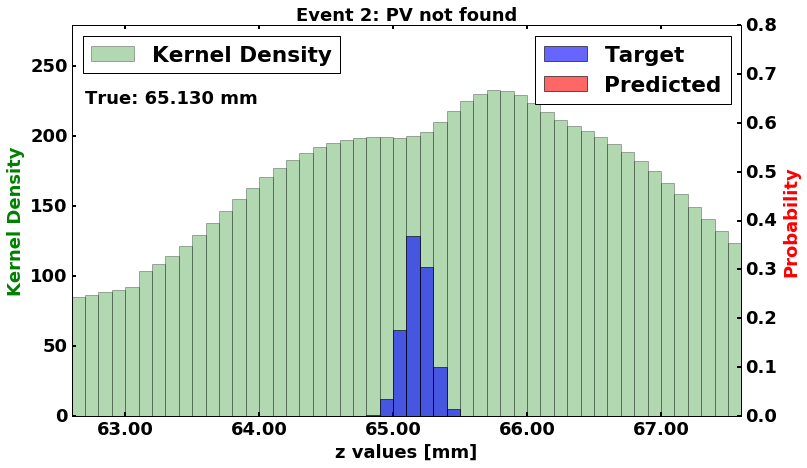

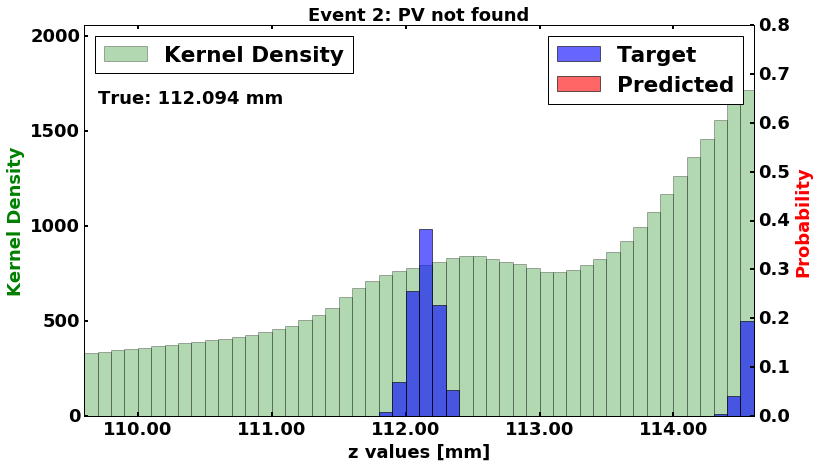

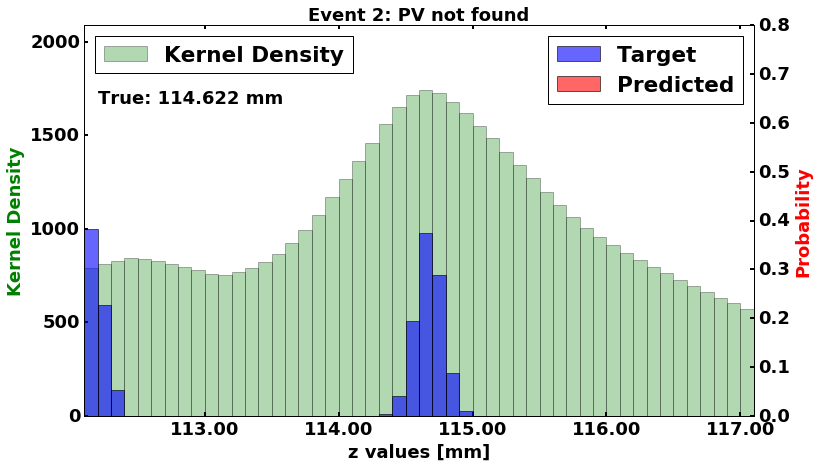

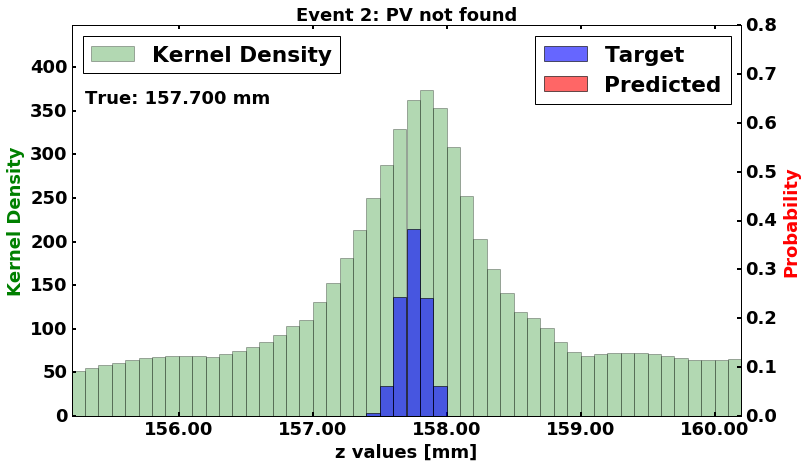

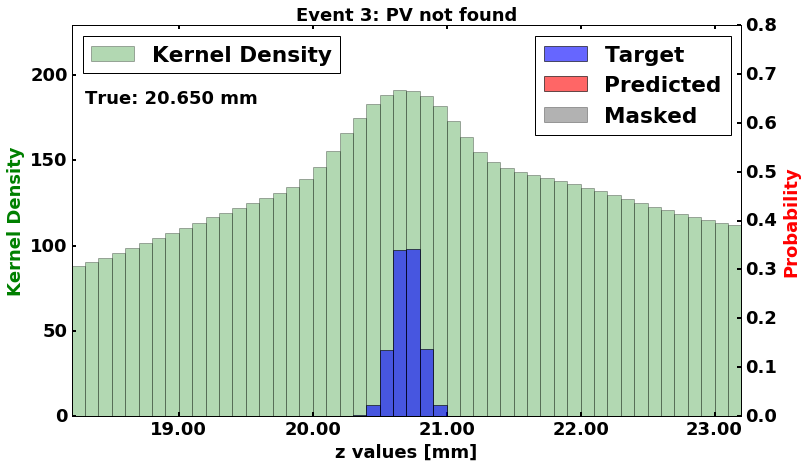

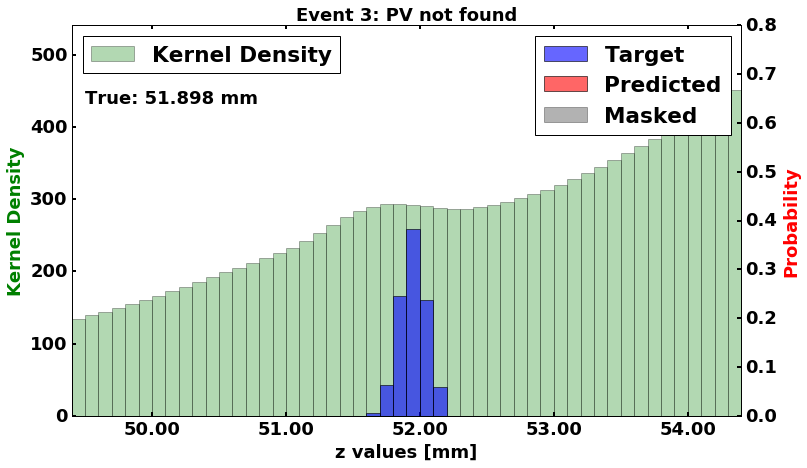

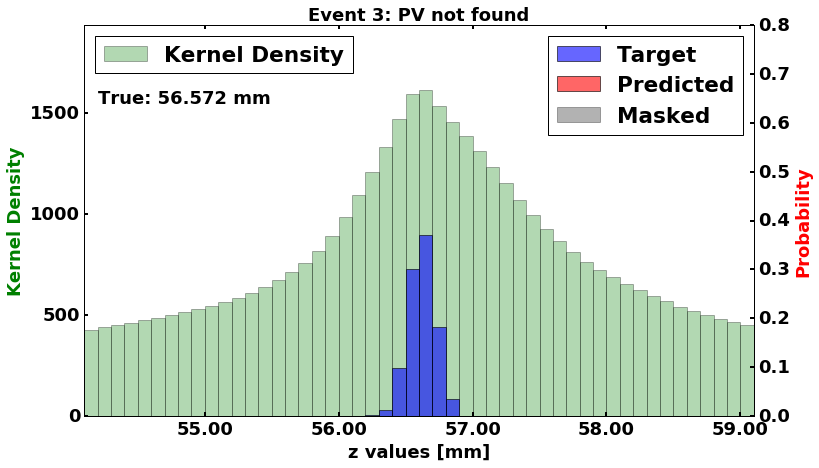

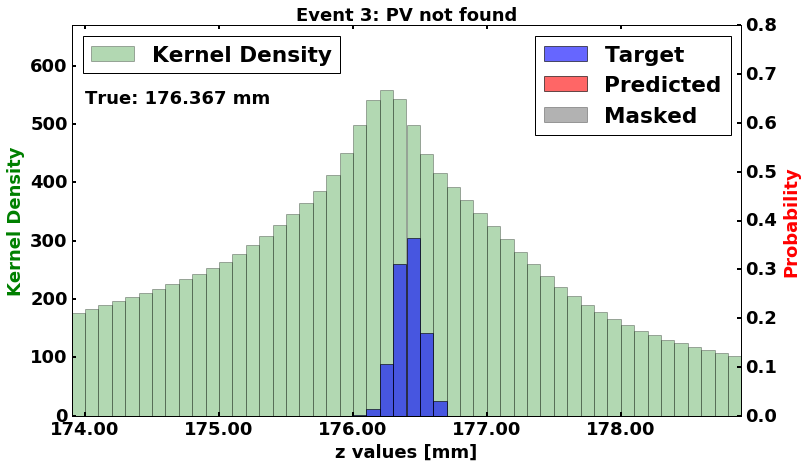

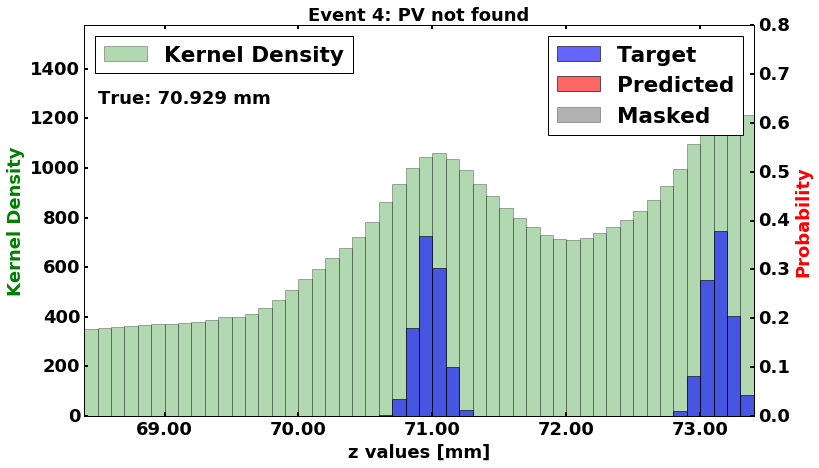

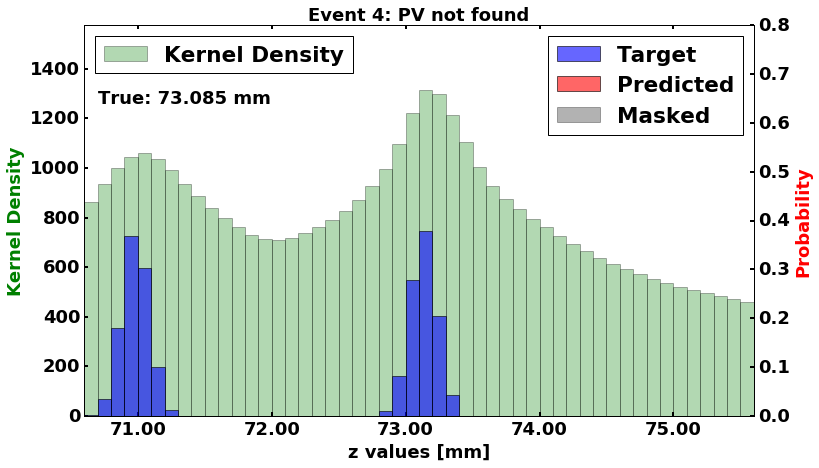

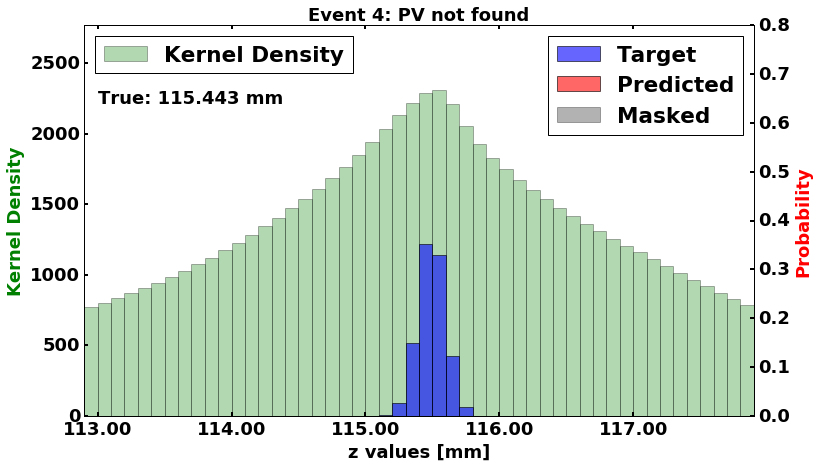

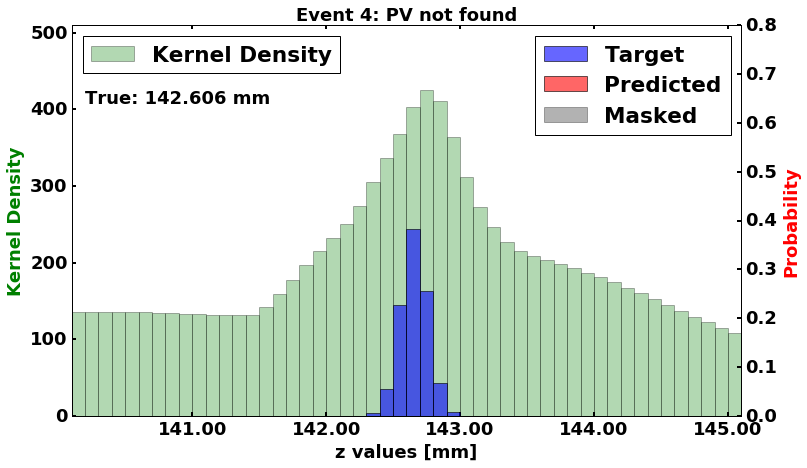

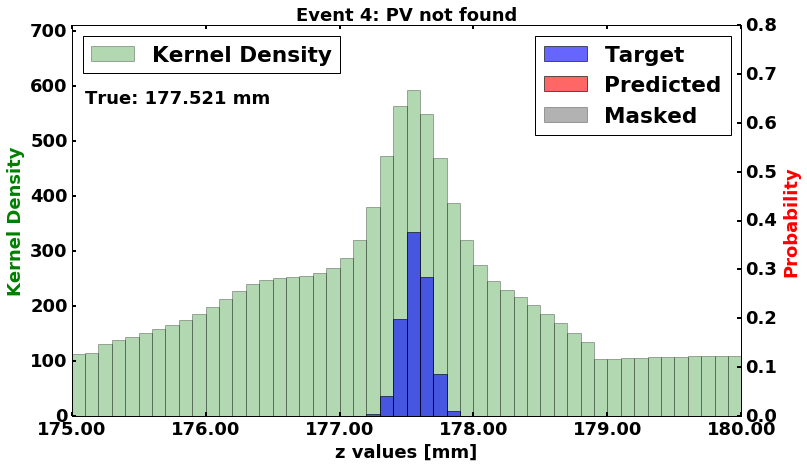

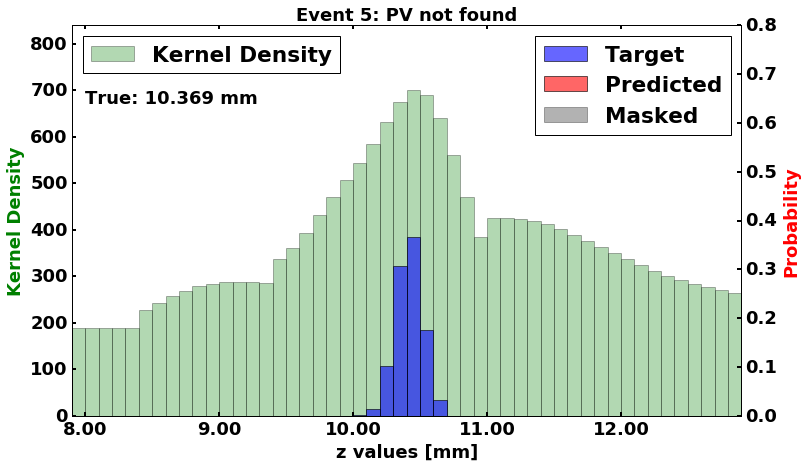

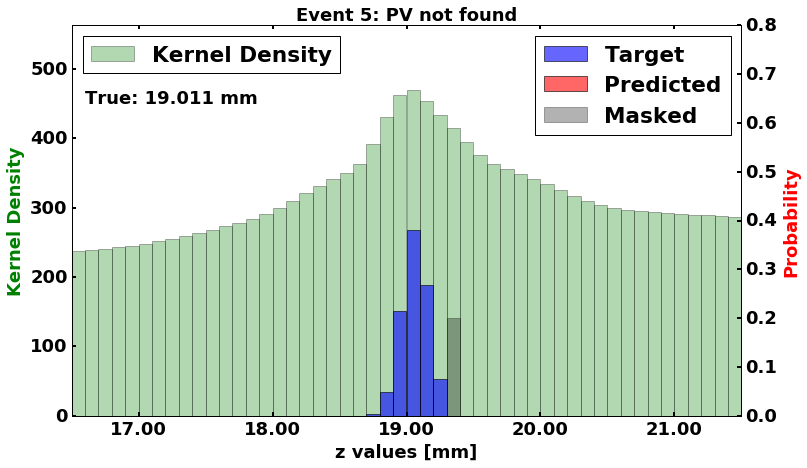

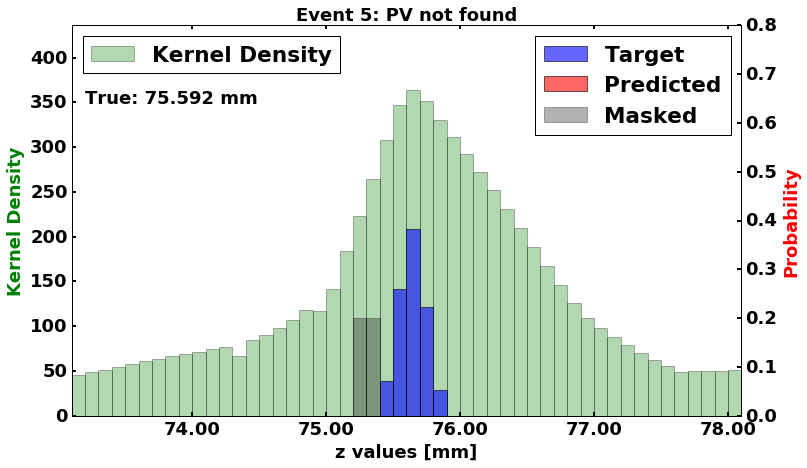

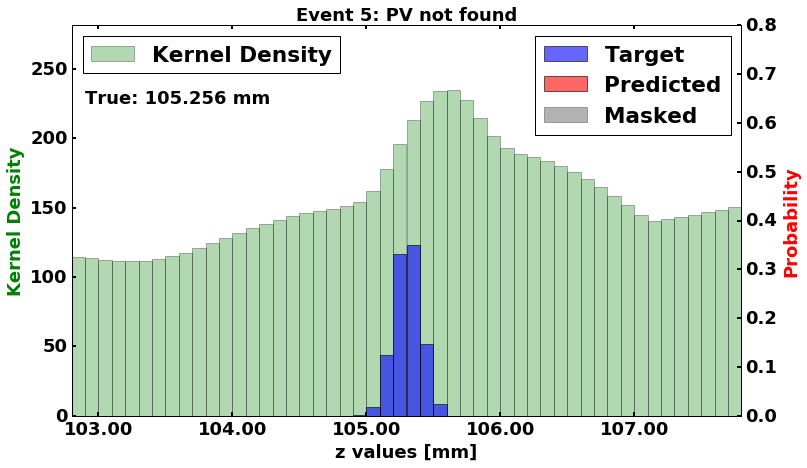

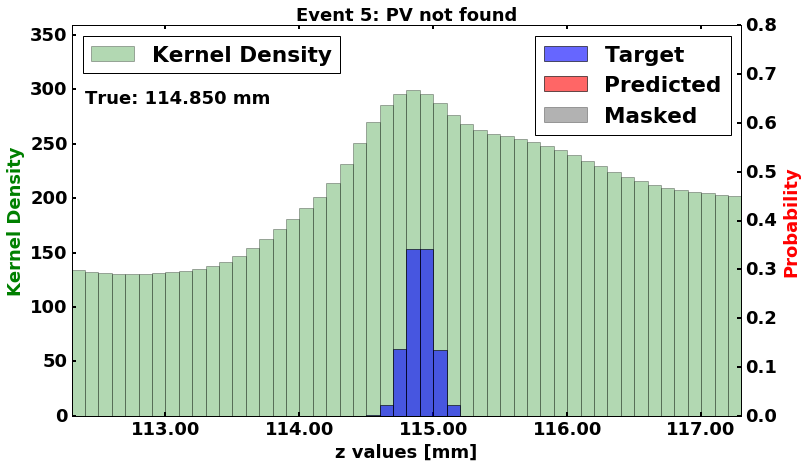

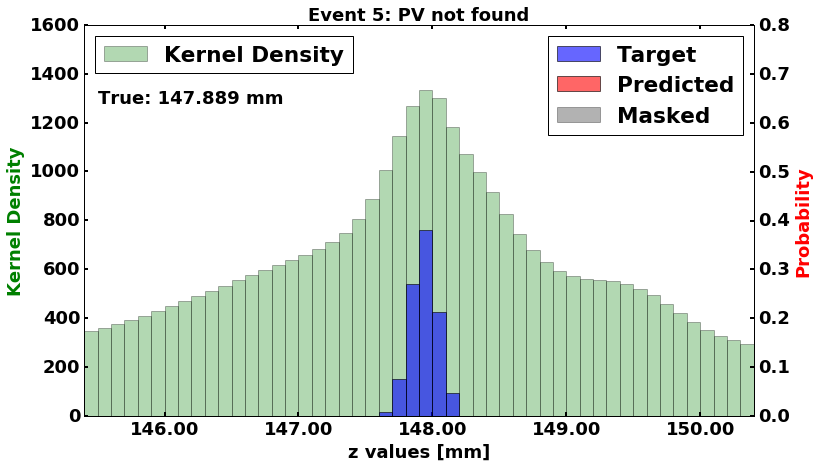

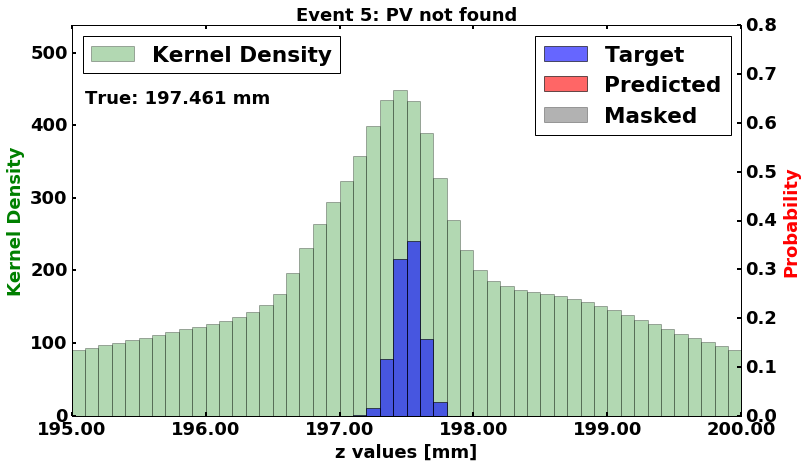

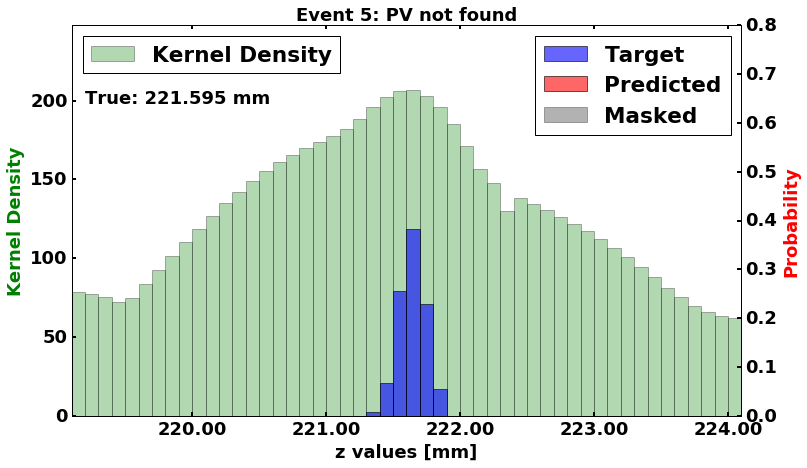

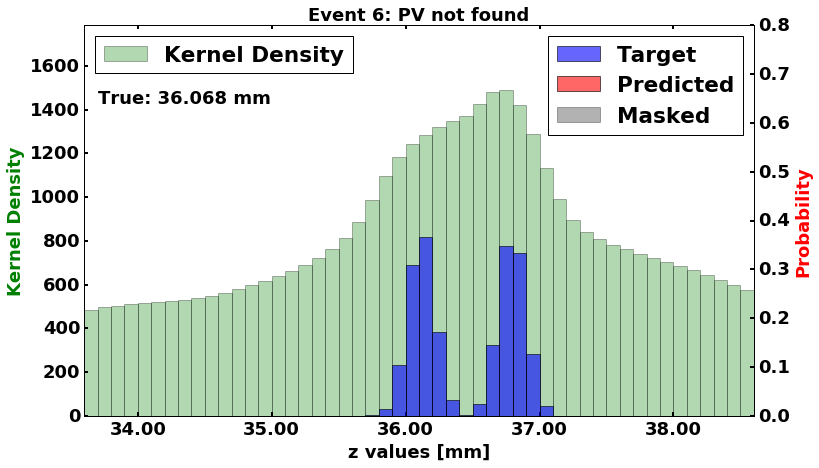

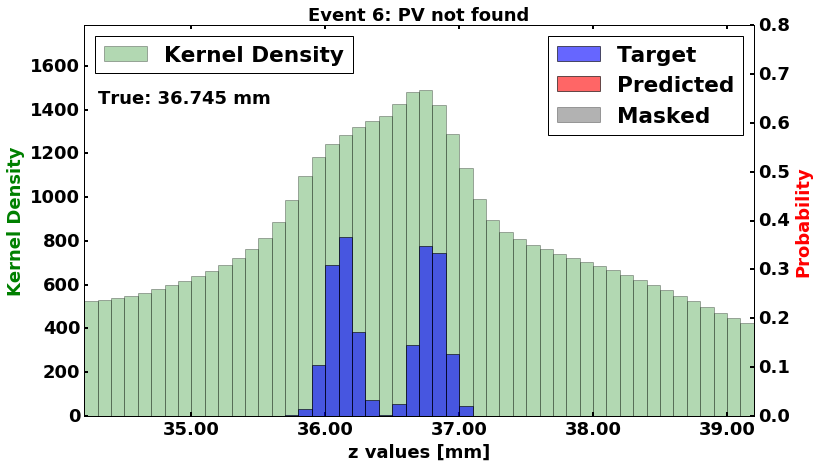

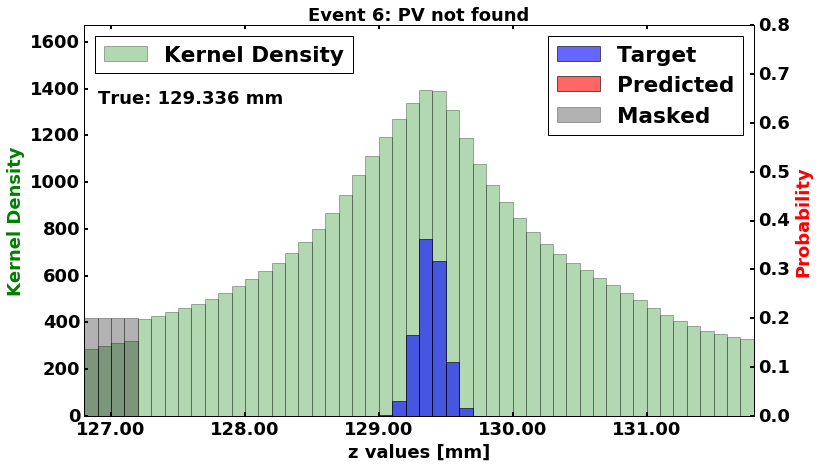

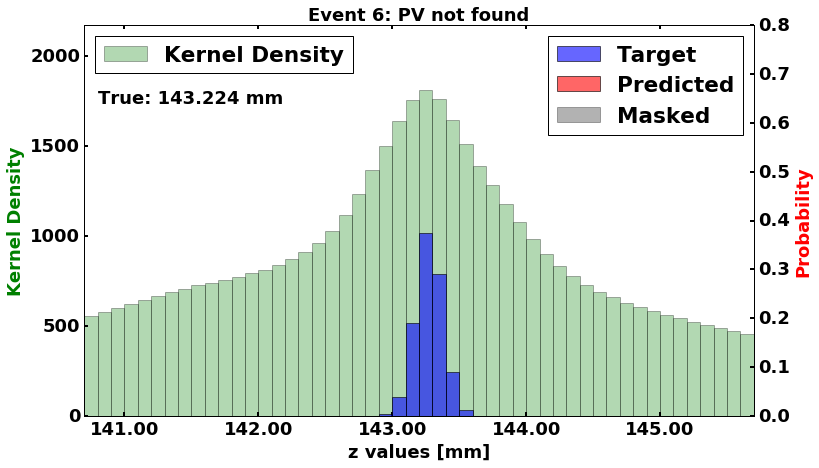

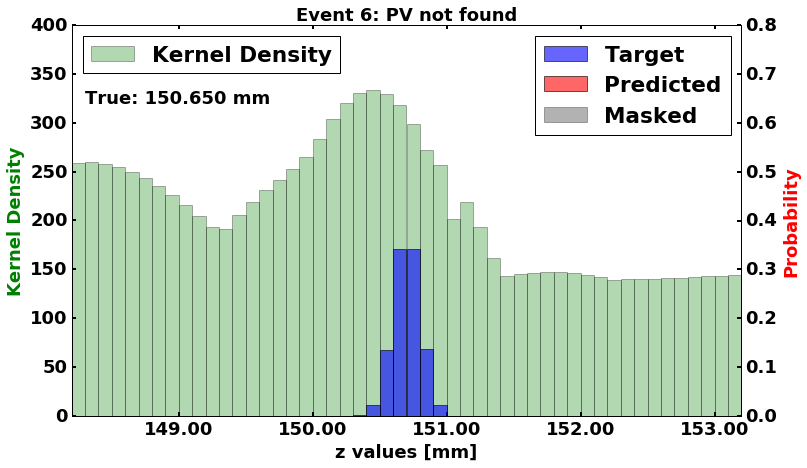

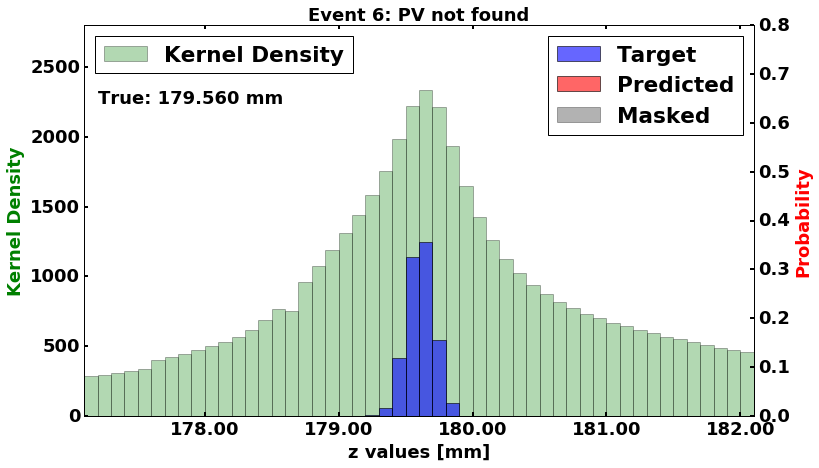

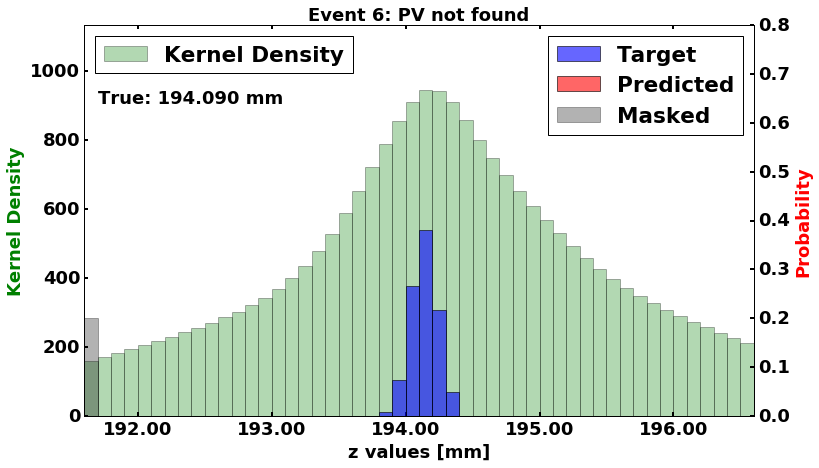

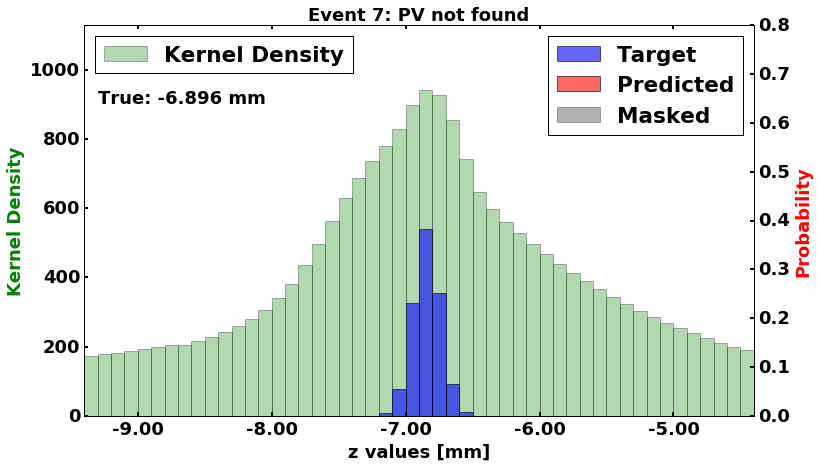

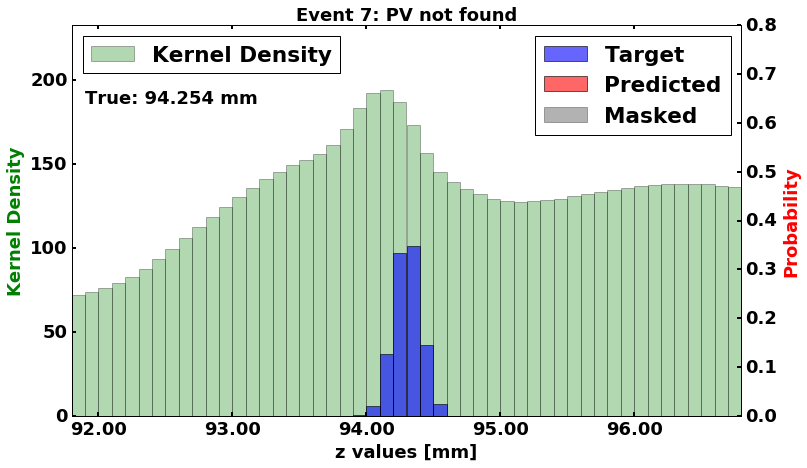

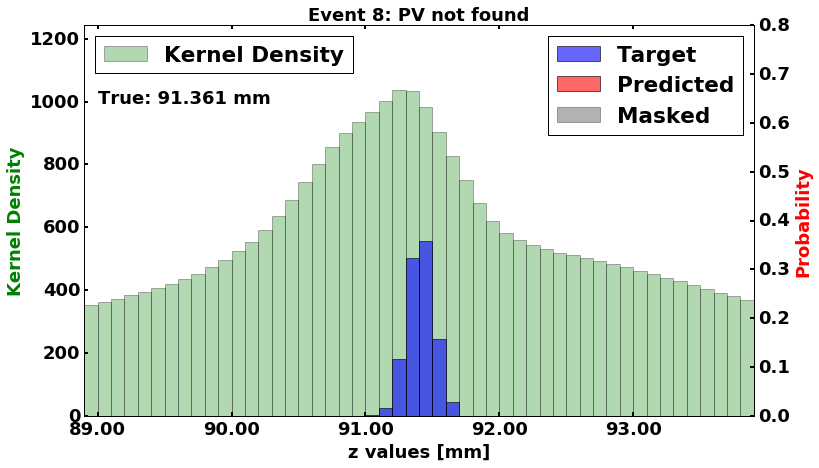

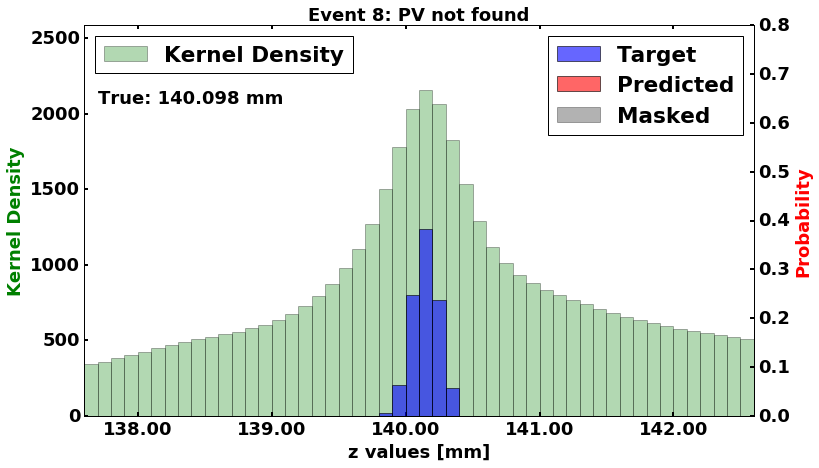

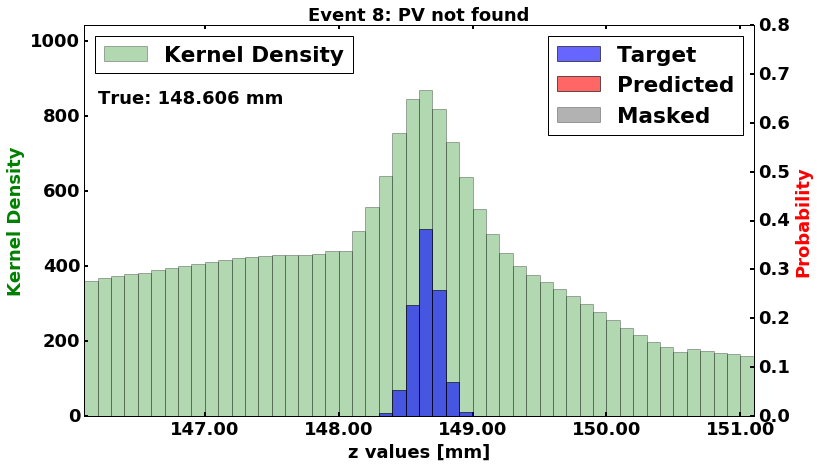

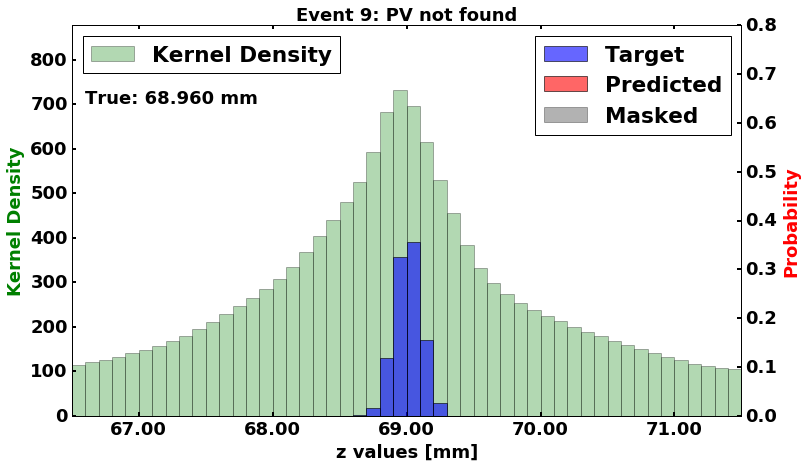

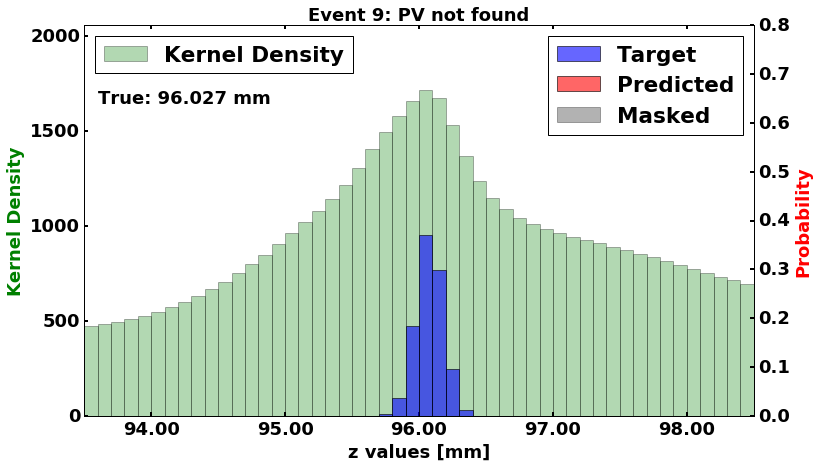

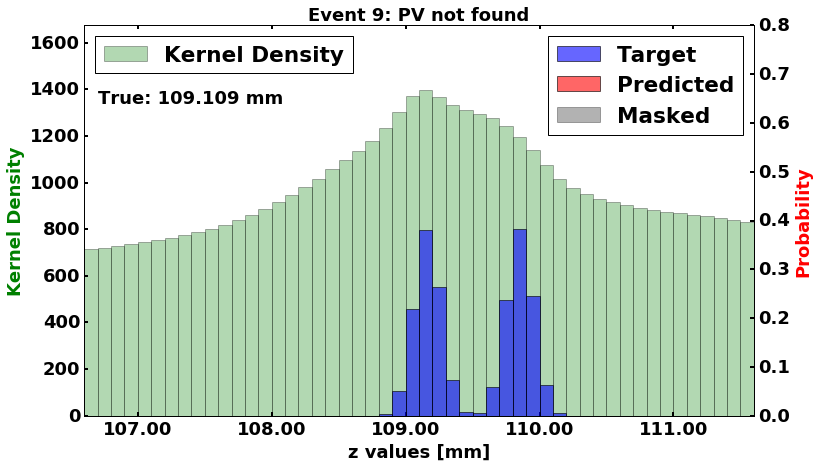

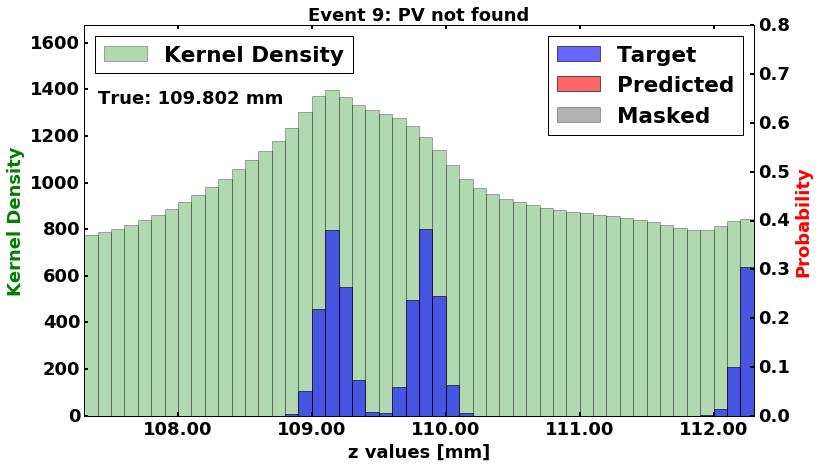

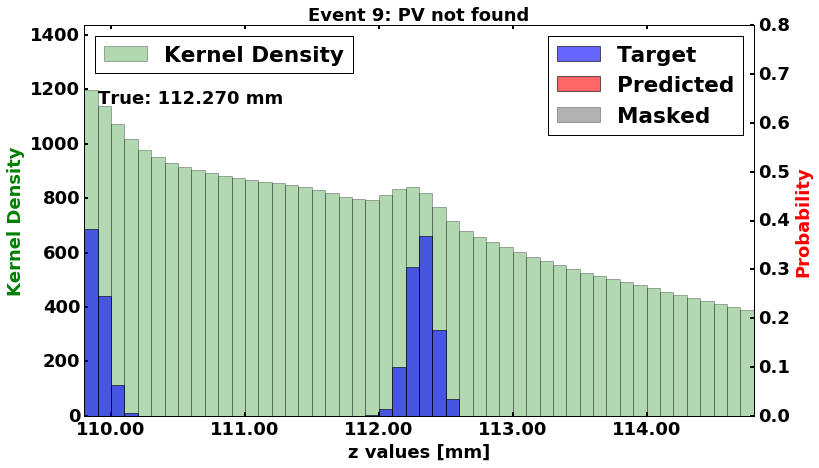

Found 0 of 4, added 0 (eff 0.00%)
Found 0 of 1, added 0 (eff 0.00%)
Found 0 of 5, added 0 (eff 0.00%)
Found 0 of 4, added 0 (eff 0.00%)
Found 0 of 5, added 0 (eff 0.00%)
Found 0 of 8, added 0 (eff 0.00%)
Found 0 of 7, added 0 (eff 0.00%)
Found 0 of 2, added 0 (eff 0.00%)
Found 0 of 3, added 0 (eff 0.00%)
Found 0 of 5, added 0 (eff 0.00%)



In [23]:
inputs = validation.dataset.tensors[0].cpu().numpy().squeeze()
zvals = np.linspace(-100, 300, 4000, endpoint=False) + 0.05
finalmsg = ''
internal_count = 0

for n in range(10):
    input = inputs[n]
    label = labels[n]
    output = outputs[n]
    
    parameters = {
        "threshold": 1e-2,
        "integral_threshold": .2,
        "min_width": 3
    }
    
    ftruth = pv_locations(label, **parameters)
    fcomputed = pv_locations(output, **parameters)
    results = efficiency(label, output, difference=5.0, **parameters)
    
    finalmsg += str(results) + '\n'
    
    truth = np.around(ftruth).astype(np.int32)
    computed = np.around(fcomputed).astype(np.int32)
    
    # Join arrays and remove any points closer than 5 bins
    poi = np.sort(np.concatenate([truth, computed]))
    poi = poi[np.concatenate([[True], np.fabs(np.diff(poi)) > 5])]
    
    for i in poi:
        b_truth = np.fabs(ftruth - i) <= 5
        b_comp = np.fabs(fcomputed - i) <= 5
        in_truth = np.any(b_truth)
        in_comp = np.any(b_comp)
        
        if in_truth and in_comp:
            msg = 'PV found'
        elif in_truth:
            msg = 'PV not found'
        else:
            msg = 'False positive'
            
        with plt.style.context({
            'font.size':18,
            'font.weight':'bold'}):
        
            ax1, ax2 = plot_ruiplot(zvals, i, input, label, output)
            ax1.set_title(f"Event {n}: {msg}", fontdict={'size':18, 'weight':'bold'})

            v = .8

            truth_centroid = (ftruth[b_truth] / 10) - 100
            for value in truth_centroid:
                ax1.text(.02, v, f"True: {value:.3f} mm",
                         transform=ax1.transAxes)
                v -= .07

            comp_centroid = (fcomputed[b_comp] / 10) - 100
            for value in comp_centroid:
                ax1.text(.02, v, f"Pred: {value:.3f} mm",
                         transform=ax1.transAxes)
                v -= .07
                
            if len(truth_centroid) == 1 and len(comp_centroid) == 1:
                diff = np.fabs(truth_centroid[0] - comp_centroid[0]) * 1_000
                ax1.text(.02, v, f"∆: {diff:.0f} µm",
                         transform=ax1.transAxes)
                v -= .07

            plt.savefig(f'120000_3layer_{internal_count:02}.pdf')
            plt.show()
            internal_count += 1
            
print(finalmsg)

In [ ]:
exit()